# Time Series Forecasting - DL Approach

In [2]:
import numpy as np
import pandas as pd
import math

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

## Deep Learning approach

In [6]:
def load_and_preprocess_data(file_path, date_col, target_col):
    data = pd.read_csv(file_path)
    data[date_col] = pd.to_datetime(data[date_col])
    data.sort_values(date_col, inplace=True)
    df = data[[target_col]]
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled = scaler.fit_transform(df)
    return df_scaled, scaler

def create_XY(data, ts=1):
    X, Y = [], []
    for i in range(len(data) - ts - 1):
        a = data[i:(i + ts), 0]
        X.append(a)
        Y.append(data[i + ts, 0])
    return np.array(X), np.array(Y)

def split_data(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    return X_train, X_test, y_train, y_test

def compile_and_train(model, X_train, y_train, X_test, y_test, epochs=100, batch_size=64):
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1)
    return model

def predict_evaluate_model(model, X, y, scaler):
    predict = model.predict(X)
    predict = scaler.inverse_transform(predict)
    rmse = math.sqrt(mean_squared_error(y, predict))
    return predict, rmse

def plot_predictions(df_scaled, train_predict, test_predict, title='Prediction'):
    train_predict_plot = np.empty_like(df_scaled)
    train_predict_plot[:, :] = np.nan
    train_predict_plot[ts:len(train_predict)+ts, :] = train_predict

    test_predict_plot = np.empty_like(df_scaled)
    test_predict_plot[:, :] = np.nan
    test_predict_plot[len(train_predict)+(ts):len(df_scaled)-1, :] = test_predict

    plt.figure(figsize=(15,6))
    plt.plot(scaler.inverse_transform(df_scaled), label='Actual')
    plt.plot(train_predict_plot, label='Train Predict')
    plt.plot(test_predict_plot, label='Test Predict')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [7]:
url1 = ('https://raw.githubusercontent.com/OrangeAVA/Mastering-Time-Series-Analysis-and-Forecasting-with-Python/refs/heads/main/ProductSalesData.csv')

### Gated Recurrent Unit (GRU)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

def build_gru_model(input_shape, units=50, dense_units=25):
    model = Sequential()
    model.add(GRU(units, return_sequences=True, input_shape=input_shape))
    model.add(GRU(units))
    model.add(Dense(dense_units))
    model.add(Dense(1))
    return model

df_scaled, scaler = load_and_preprocess_data(url1, 'Date', 'Units Sold')
ts = 3

X, Y = create_XY(df_scaled, ts=ts)

X_train, X_test, y_train, y_test = split_data(X, Y)

model = build_gru_model(input_shape=(3, 1))
model = compile_and_train(model, X_train, y_train, X_test, y_test)

Epoch 1/100
63/63 [==============================] - 9s 30ms/step - loss: 0.0356 - val_loss: 0.0285
Epoch 2/100
63/63 [==============================] - 1s 8ms/step - loss: 0.0295 - val_loss: 0.0284
Epoch 3/100
63/63 [==============================] - 0s 8ms/step - loss: 0.0296 - val_loss: 0.0285
Epoch 4/100
63/63 [==============================] - 0s 8ms/step - loss: 0.0297 - val_loss: 0.0285
Epoch 5/100
63/63 [==============================] - 0s 7ms/step - loss: 0.0295 - val_loss: 0.0284
Epoch 6/100
63/63 [==============================] - 1s 8ms/step - loss: 0.0299 - val_loss: 0.0284
Epoch 7/100
63/63 [==============================] - 0s 8ms/step - loss: 0.0295 - val_loss: 0.0289
Epoch 8/100
63/63 [==============================] - 1s 8ms/step - loss: 0.0297 - val_loss: 0.0289
Epoch 9/100
63/63 [==============================] - 1s 8ms/step - loss: 0.0298 - val_loss: 0.0285
Epoch 10/100
63/63 [==============================] - 1s 8ms/step - loss: 0.0297 - val_loss: 0.0284
Epoch 11

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3, 50)             7950      
                                                                 
 gru_1 (GRU)                 (None, 50)                15300     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 24551 (95.90 KB)
Trainable params: 24551 (95.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
train_predict, train_rmse = predict_evaluate_model(model, X_train, y_train, scaler)
test_predict, test_rmse =  predict_evaluate_model(model, X_test, y_test, scaler)

32/32 [==============================] - 0s 3ms/step


In [12]:
print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")

Train RMSE: 388.0602368613975, Test RMSE: 381.6428437140761


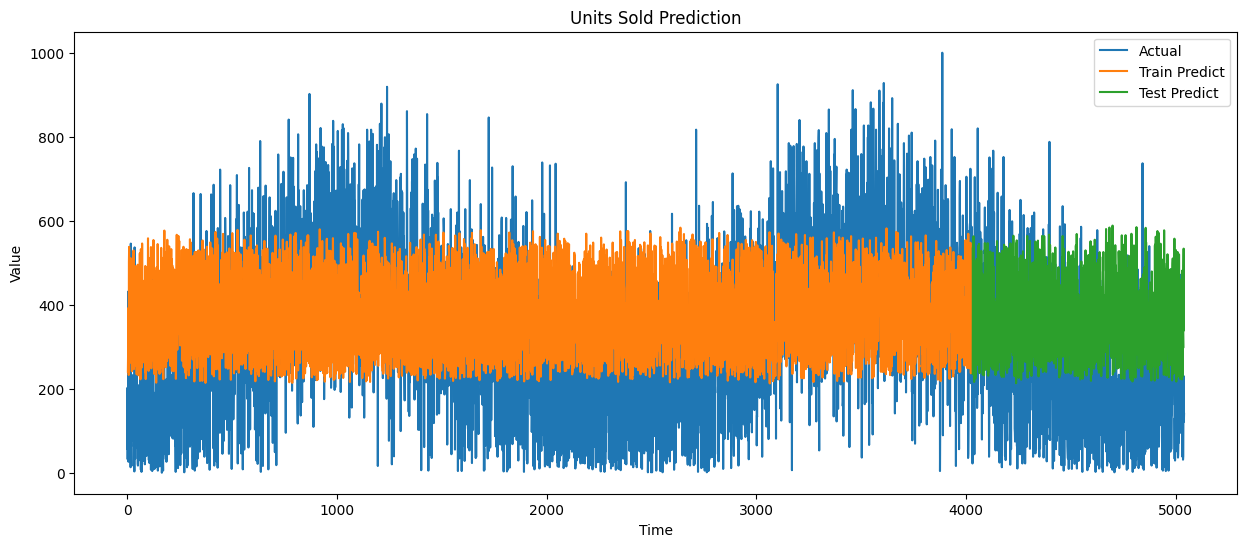

In [13]:
plot_predictions(df_scaled, train_predict, test_predict, 'Units Sold Prediction')

## Convolutional Neural Networks (CNN)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

def build_cnn_model(filters=64, 
                    kernel_size=2, 
                    activation='relu', 
                    dense_units = 50, 
                    time_step = 3, 
                    pool_size=2):
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=(time_step, 1)))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(dense_units, activation=activation))
    model.add(Dense(1))
    return model

df_scaled, scaler = load_and_preprocess_data(url1, 'Date', 'Units Sold')
ts = 3

X, Y = create_XY(df_scaled, ts=ts)
X_train, X_test, y_train, y_test = split_data(X, Y)

model = build_cnn_model(filters=64, 
                        kernel_size=2, 
                        activation='relu', 
                        dense_units = 50, 
                        time_step = 3, 
                        pool_size=2)

model = compile_and_train(model, X_train, y_train, X_test, y_test)

Epoch 1/100
63/63 [==============================] - 2s 7ms/step - loss: 0.0503 - val_loss: 0.0301
Epoch 2/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0308 - val_loss: 0.0290
Epoch 3/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0301 - val_loss: 0.0288
Epoch 4/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0298 - val_loss: 0.0287
Epoch 5/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0299 - val_loss: 0.0287
Epoch 6/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0298 - val_loss: 0.0287
Epoch 7/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0298 - val_loss: 0.0286
Epoch 8/100
63/63 [==============================] - 0s 3ms/step - loss: 0.0298 - val_loss: 0.0286
Epoch 9/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0298 - val_loss: 0.0286
Epoch 10/100
63/63 [==============================] - 0s 3ms/step - loss: 0.0297 - val_loss: 0.0291
Epoch 11/

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 64)             192       
                                                                 
 max_pooling1d (MaxPooling1  (None, 1, 64)             0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                3250      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3493 (13.64 KB)
Trainable params: 3493 (13.64 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [17]:
train_predict, train_rmse = predict_evaluate_model(model, X_train, y_train, scaler)
test_predict, test_rmse =  predict_evaluate_model(model, X_test, y_test, scaler)

32/32 [==============================] - 0s 1ms/step


In [18]:
print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")

Train RMSE: 349.1904102129251, Test RMSE: 342.9014164190013


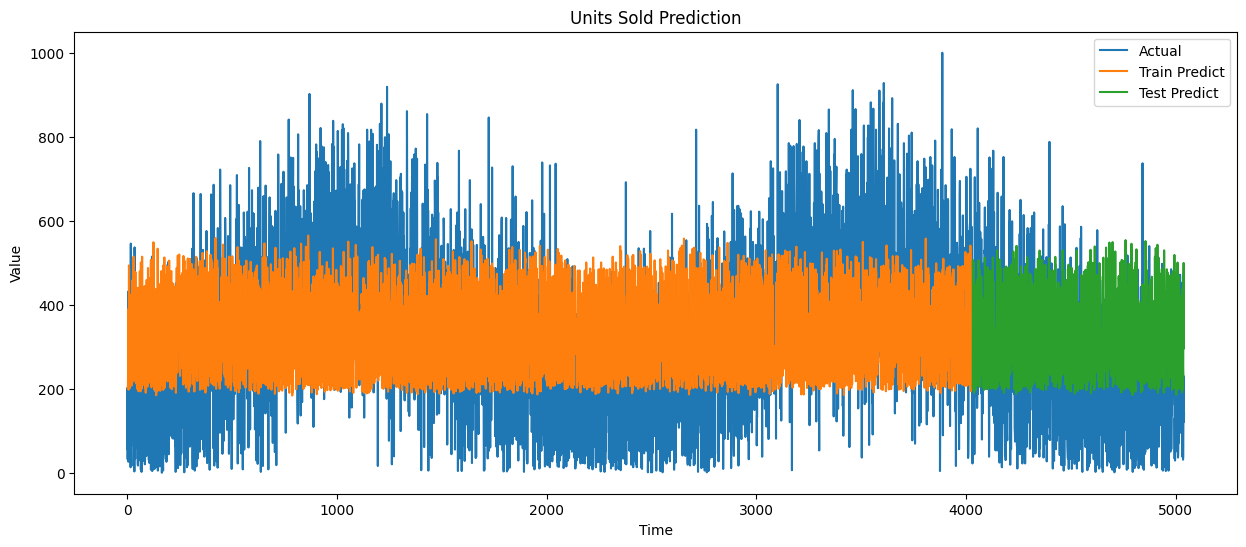

In [19]:
plot_predictions(df_scaled, train_predict, test_predict, 'Units Sold Prediction')

### LSTM Model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def build_lstm_model(input_shape, 
                     units=50, 
                     dense_units=25):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dense(dense_units))
    model.add(Dense(1))
    return model

df_scaled, scaler = load_and_preprocess_data(url1, 'Date', 'Units Sold')
ts = 3

X, Y = create_XY(df_scaled, ts=ts)

X_train, X_test, y_train, y_test = split_data(X, Y)

model = build_lstm_model(input_shape=(3, 1))
model = compile_and_train(model, X_train, y_train, X_test, y_test)

train_predict, train_rmse = predict_evaluate_model(model, X_train, y_train, scaler)
test_predict, test_rmse =  predict_evaluate_model(model, X_test, y_test, scaler)

Epoch 1/100
63/63 [==============================] - 15s 63ms/step - loss: 0.0424 - val_loss: 0.0298
Epoch 2/100
63/63 [==============================] - 1s 9ms/step - loss: 0.0300 - val_loss: 0.0288
Epoch 3/100
63/63 [==============================] - 1s 9ms/step - loss: 0.0298 - val_loss: 0.0287
Epoch 4/100
63/63 [==============================] - 1s 9ms/step - loss: 0.0297 - val_loss: 0.0291
Epoch 5/100
63/63 [==============================] - 1s 10ms/step - loss: 0.0299 - val_loss: 0.0288
Epoch 6/100
63/63 [==============================] - 1s 10ms/step - loss: 0.0297 - val_loss: 0.0286
Epoch 7/100
63/63 [==============================] - 1s 9ms/step - loss: 0.0295 - val_loss: 0.0286
Epoch 8/100
63/63 [==============================] - 1s 9ms/step - loss: 0.0295 - val_loss: 0.0285
Epoch 9/100
63/63 [==============================] - 1s 10ms/step - loss: 0.0296 - val_loss: 0.0286
Epoch 10/100
63/63 [==============================] - 1s 11ms/step - loss: 0.0296 - val_loss: 0.0288
Epo

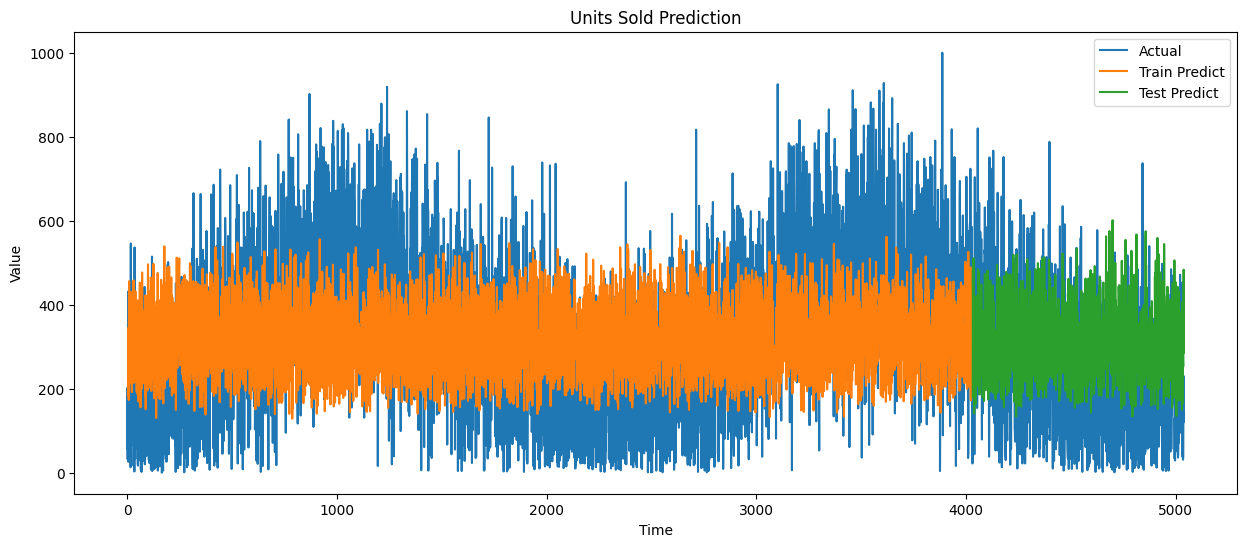

In [22]:
plot_predictions(df_scaled, train_predict, test_predict, 'Units Sold Prediction')